# SY09 : Analyse descriptive de Starbucks Drinks

https://github.com/rfordatascience/tidytuesday/tree/master/data/2021/2021-12-21

## Import des données

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
from sklearn.decomposition import PCA
import numpy as np

In [175]:
starbucks = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-12-21/starbucks.csv')
print(starbucks.shape, "\n")
print(starbucks.columns)

(1147, 15) 

Index(['product_name', 'size', 'milk', 'whip', 'serv_size_m_l', 'calories',
       'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg',
       'sodium_mg', 'total_carbs_g', 'fiber_g', 'sugar_g', 'caffeine_mg'],
      dtype='object')


## Nettoyage des données

Toutes les variables quantitatives sont bien typées.
*Size* est une catégorie que l'on crée à partir de ses valeurs uniques.
*Milk* est une catégorie que l'on renomme ici pour la lisibilité des graphiques.
*Whip* est booléen.

In [176]:
starbucks["size"] = pd.Categorical(starbucks["size"], categories = starbucks["size"].unique())

starbucks["milk"] = starbucks['milk'].replace(0,"none")
starbucks["milk"] = starbucks['milk'].replace(1,"nonfat")
starbucks["milk"] = starbucks['milk'].replace(2,"2%")
starbucks["milk"] = starbucks['milk'].replace(3,"soy")
starbucks["milk"] = starbucks['milk'].replace(4,"coconut")
starbucks["milk"] = starbucks['milk'].replace(5,"whole")
starbucks["milk"] = pd.Categorical(starbucks["milk"], categories = starbucks["milk"].unique())

starbucks["whip"] = starbucks["whip"].astype("bool")

En se basant sur le travail de https://rpubs.com/saravargha/starbucks, on va essayer de créer une variable qui catégorise les boissons en fonction de leur nom.

Ses catégories sont : *Refresher*, *Smoothie*, *Tea*, *Coffee*, *Espresso*, *Frapuccino*, *Hot Chocolates & Others*

L'autrice ne fournit pas le code qui lui a permis de créer cette variable.

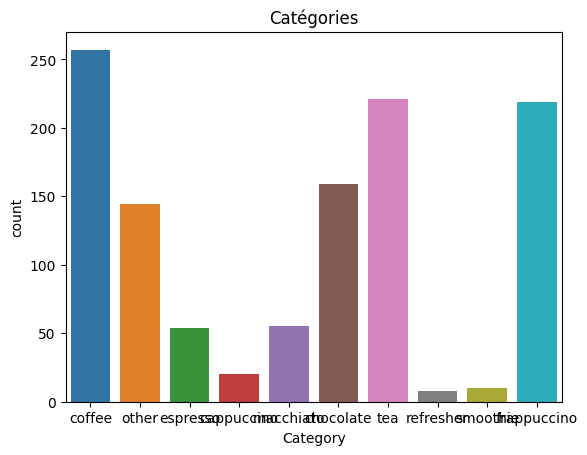

Other :  ['Vanilla Sweet Cream Cold Brew' 'Cinnamon Dolce Latte' 'Flat White'
 'Skinny Cinnamon Dolce Latte' 'Iced Skinny Cinnamon Dolce Latte'
 'Skinny Mocha' 'Iced Skinny Mocha' 'Starbucks Doubleshot on ice'
 'Oprah Cinnamon Chai Latte' 'Iced Oprah Cinnamon Chai Latte'
 'Blended Strawberry Lemonade' 'Caramel Apple Spice' 'Lemonade'
 'Protein & Fibre Powder']


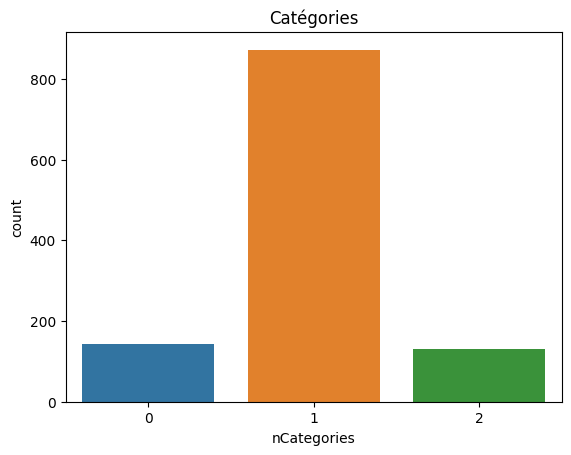

Il y a  11  produits concernés.
Les produits sont :  ['Espresso - Caffè Americano' 'Espresso - Iced Caffè Americano'
 'Espresso Macchiato' 'Chocolate Smoothie'
 'Caffè Vanilla Frappuccino Blended' 'Coffee Frappuccino Blended'
 'Espresso Frappuccino Blended' 'Caffè Vanilla Frappuccino Light'
 'Coffee Frappuccino Light' 'Espresso Frappuccino Light'
 'Green Tea Crème Frappuccino Blended']
Cela concerne  131  lignes.

Espresso - Caffè Americano  	  ['espresso']
Espresso - Iced Caffè Americano  	  ['espresso']
Espresso Macchiato  	  ['espresso']
Chocolate Smoothie  	  ['chocolate']
Caffè Vanilla Frappuccino Blended  	  ['coffee']
Coffee Frappuccino Blended  	  ['coffee']
Espresso Frappuccino Blended  	  ['espresso']
Caffè Vanilla Frappuccino Light  	  ['coffee']
Coffee Frappuccino Light  	  ['coffee']
Espresso Frappuccino Light  	  ['espresso']
Green Tea Crème Frappuccino Blended  	  ['tea']
C'est la première occurence qui est conservée, on peut partir du principe que c'est celle qui décrit

In [177]:
# On crée les catégories par une expression regex et str.extract
starbucks["Category"] = starbucks["product_name"].str.lower().str.extract("(caffè|chocolate|refresher|smoothie|tea|coffee|espresso|frappuccino|cappuccino|macchiato)")[0]
starbucks['Category'] = starbucks['Category'].fillna('other')
starbucks["Category"] = starbucks['Category'].replace('caffè',"coffee")

# On affiche la répartition obtenue
sns.countplot(x="Category",data=starbucks).set(title='Catégories')
plot.show()

# On vérifie la catégorie "other"
test_cat = starbucks[starbucks['Category'] == 'other']
print("Other : ", test_cat["product_name"].unique())

# Certains produits sont dans deux catégories, on peut utiliser str.extractall mais ça peut être difficile à exploiter
#print(starbucks[starbucks["product_name"]=="Espresso - Caffè Americano"]["product_name"].str.lower().str.extractall("(caffè|chocolate|refresher|smoothie|tea|coffee|espresso|frappuccino|cappuccino|macchiato)"))

# On peut plus simplement compter le nombre de catégories de chaque produit
starbucks["nCategories"] = starbucks["product_name"].str.lower().str.count("(caffè|chocolate|refresher|smoothie|tea|coffee|espresso|frappuccino|cappuccino|macchiato)")

# On affiche la répartition du nombre de catégorie (0 signifie 'other')
sns.countplot(x="nCategories",data=starbucks).set(title='Catégories')
plot.show()

# On peut afficher le nombre de produits concernés par deux catégories
print("Il y a ", starbucks[starbucks["nCategories"]==2]["product_name"].nunique(), " produits concernés.")
print("Les produits sont : ", starbucks[starbucks["nCategories"]==2]["product_name"].unique())
print("Cela concerne ", starbucks[starbucks["nCategories"]==2]["product_name"].count(), " lignes.\n")

# On peut explorer l'attribution de ces 11 cas pour voir si un traitement est nécessaire
for i in starbucks[starbucks["nCategories"]==2]["product_name"].unique():
    print(i, " \t ", starbucks[starbucks["product_name"]==i]["Category"].unique())
    
print("C'est la première occurence qui est conservée, on peut partir du principe que c'est celle qui décrit le mieux le produit et conserver la catégorisation.")

## Exploration des variables qualitatives

### *Category* : La catégorie de boisson

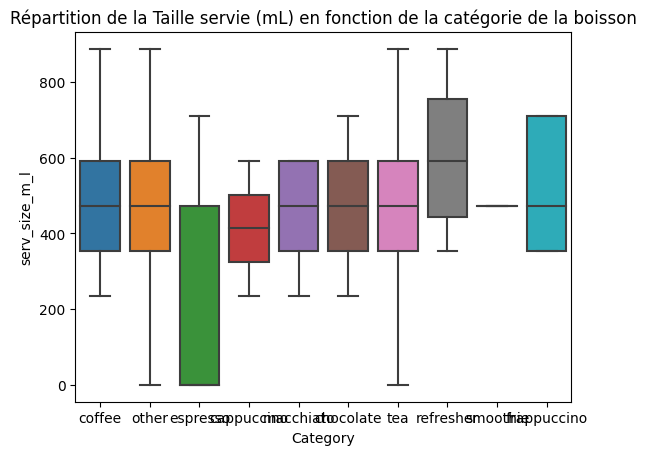

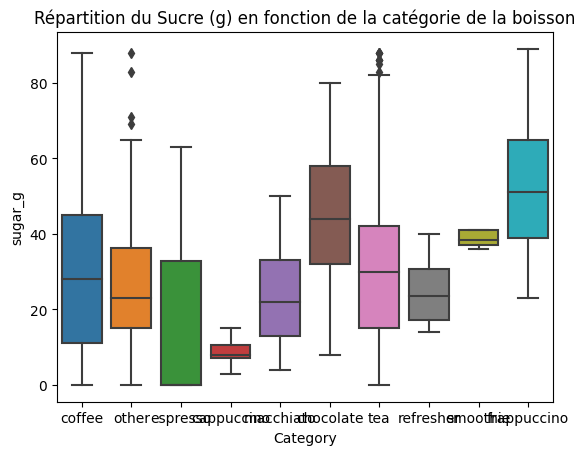

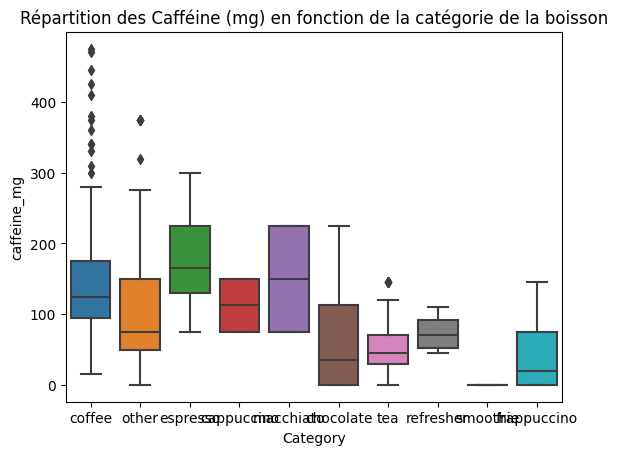

In [178]:
sns.boxplot(
    x="Category",
    y="serv_size_m_l",
    data=starbucks
    ).set(title='Répartition de la Taille servie (mL) en fonction de la catégorie de la boisson')
plot.show()

sns.boxplot(
    x="Category",
    y="sugar_g",
    data=starbucks
    ).set(title='Répartition du Sucre (g) en fonction de la catégorie de la boisson')
plot.show()

sns.boxplot(
    x="Category",
    y="caffeine_mg",
    data=starbucks
    ).set(title='Répartition des Cafféine (mg) en fonction de la catégorie de la boisson')
plot.show()

### *Product_Name* : Le nom des produits

On a créé *Category* à partir de cette variable. On peut vérifier l'unicité des noms de boissons.

In [179]:
print(starbucks["product_name"].nunique())
print(starbucks["product_name"].count())

93
1147


### *Milk* : Le type de lait 

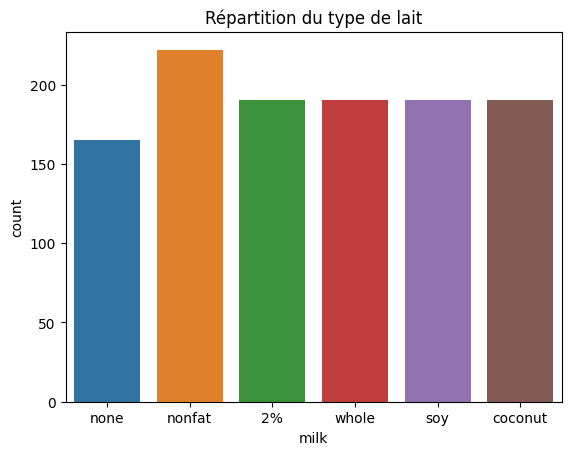

In [180]:
sns.countplot(x="milk",data=starbucks).set(title='Répartition du type de lait')
plot.show()

### *Size* : La taille de la boisson

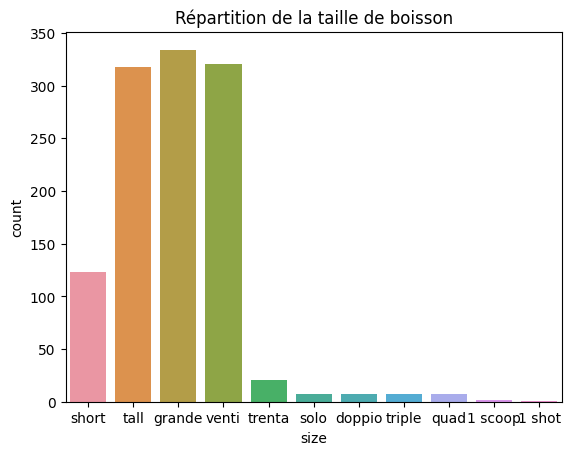

In [181]:
sns.countplot(x="size",data=starbucks).set(title='Répartition de la taille de boisson')
plot.show()

On observe plus de valeurs que ce qui était décrit dans la description du jeu de données. On peut parcourir les tailles atypiques.

In [182]:
print("Trenta")
print(starbucks[starbucks["size"] == "trenta"].shape)
print(starbucks[starbucks["size"] == "trenta"]["product_name"].unique())
print(starbucks[starbucks["size"] == "trenta"]["Category"].unique())
print("\n")

print("Solo")
print(starbucks[starbucks["size"] == "solo"].shape)
print(starbucks[starbucks["size"] == "solo"]["product_name"].unique())
print(starbucks[starbucks["size"] == "solo"]["Category"].unique())
print("\n")

print("Doppio")
print(starbucks[starbucks["size"] == "doppio"].shape)
print(starbucks[starbucks["size"] == "doppio"]["product_name"].unique())
print(starbucks[starbucks["size"] == "doppio"]["Category"].unique())
print("\n")

print("Triple")
print(starbucks[starbucks["size"] == "triple"].shape)
print(starbucks[starbucks["size"] == "triple"]["product_name"].unique())
print(starbucks[starbucks["size"] == "triple"]["Category"].unique())
print("\n")

print("Quad")
print(starbucks[starbucks["size"] == "quad"].shape)
print(starbucks[starbucks["size"] == "quad"]["product_name"].unique())
print(starbucks[starbucks["size"] == "quad"]["Category"].unique())
print("\n")

print("1 scoop")
print(starbucks[starbucks["size"] == "1 scoop"].shape)
print(starbucks[starbucks["size"] == "1 scoop"]["product_name"].unique())
print(starbucks[starbucks["size"] == "1 scoop"]["Category"].unique())
print("\n")

print("1 shot")
print(starbucks[starbucks["size"] == "1 shot"].shape)
print(starbucks[starbucks["size"] == "1 shot"]["product_name"].unique())
print(starbucks[starbucks["size"] == "1 shot"]["Category"].unique())

Trenta
(21, 17)
['Iced Coffee' 'Iced Coffee with milk' 'Cold Brewed Coffee'
 'Vanilla Sweet Cream Cold Brew' 'Iced Black tea'
 'Iced Black tea Lemonade' 'Iced Green Tea' 'Iced Green Tea Lemonade'
 'Iced Mango Black Tea' 'Iced Mango Black Tea Lemonade'
 'Iced Passion Tango Tea' 'Iced Passion Tango Tea Lemonade'
 'Peach Iced Green Tea' 'Peach Iced Green Tea Lemonade'
 'Cool Lime Starbucks Refreshers'
 'Very Berry Hibiscus Starbucks Refreshers' 'Lemonade']
['coffee' 'other' 'tea' 'refresher']


Solo
(7, 17)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


Doppio
(7, 17)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


Triple
(7, 17)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


Quad
(7, 17)
['Espresso' 'Espresso con panna' 'Espresso Macchiato']
['espresso']


1 scoop
(2, 17)
['Protein & Fibre Powder' 'Matcha Green Tea Powder']
['other' 'tea']


1 shot
(1, 17)
['Espresso shot']
['espresso']


On peut s'intéresser à la variable *serv_size_m_l* qui chiffre en mL la taille de la boisson, et à son lien avec notre variable qualitative.

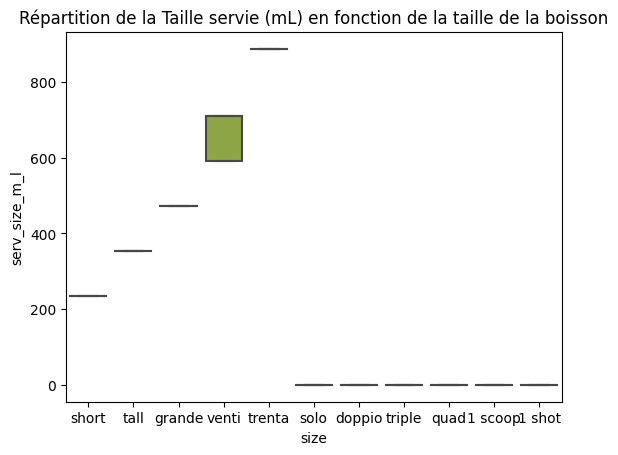

In [183]:
sns.boxplot(
    x="size",
    y="serv_size_m_l",
    data=starbucks
    ).set(title='Répartition de la Taille servie (mL) en fonction de la taille de la boisson')
plot.show()

On se rend compte que les deux variables sont extrêmement liées, on peut vérifier ce qu'il en est pour la taille *venti*.

<Axes: xlabel='serv_size_m_l', ylabel='count'>

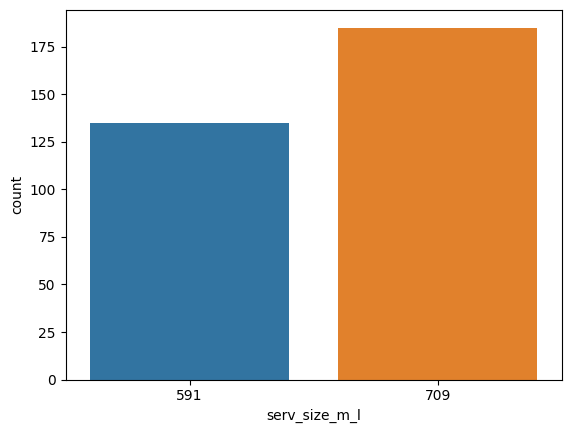

In [184]:
sns.countplot(x="serv_size_m_l",data=starbucks[starbucks['size'] == 'venti'])

On peut vérifier l'influence de la taille sur le sucre contenu dans la boisson.

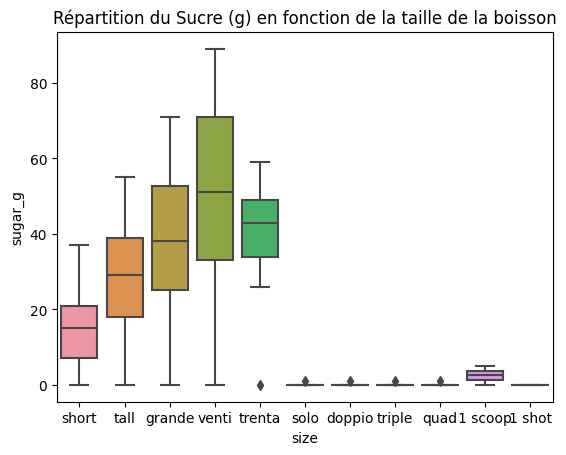

In [185]:
sns.boxplot(
    x="size",
    y="sugar_g",
    data=starbucks
    ).set(title='Répartition du Sucre (g) en fonction de la taille de la boisson')
plot.show()

On peut faire de même avec les calories.

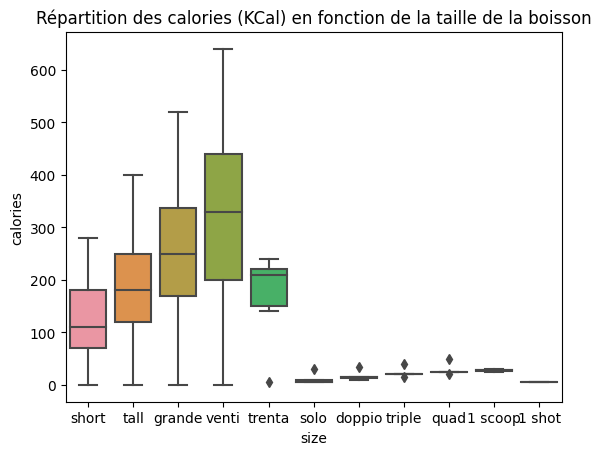

In [186]:
sns.boxplot(
    x="size",
    y="calories",
    data=starbucks
    ).set(title='Répartition des calories (KCal) en fonction de la taille de la boisson')
plot.show()

### *Whip* : La boisson a été fouettée ou non

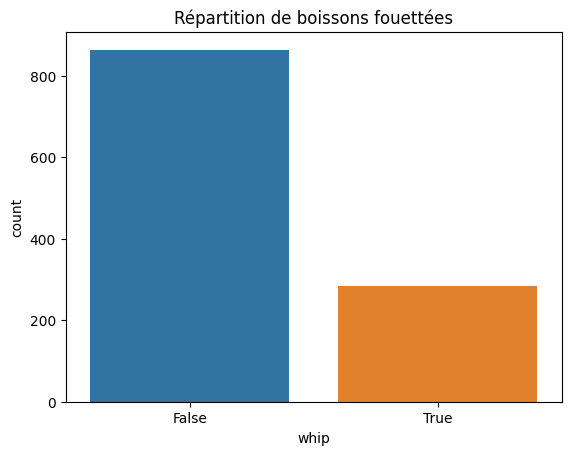

In [187]:
sns.countplot(x="whip",data=starbucks).set(title='Répartition de boissons fouettées')
plot.show()

On peut vérifier l'influence qu'a la variable *whip* sur les autres.

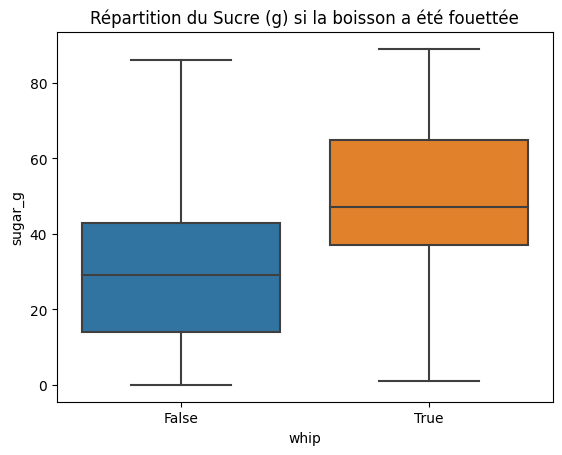

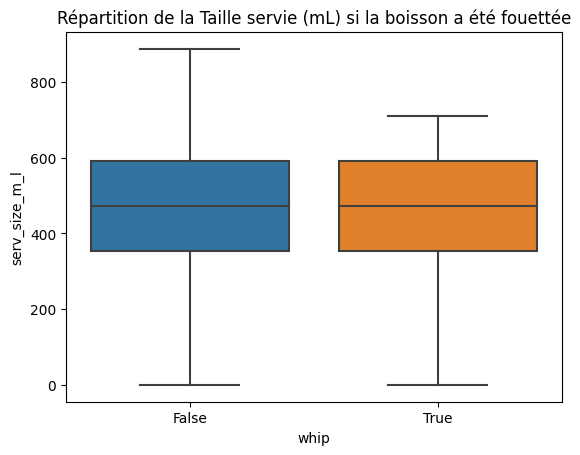

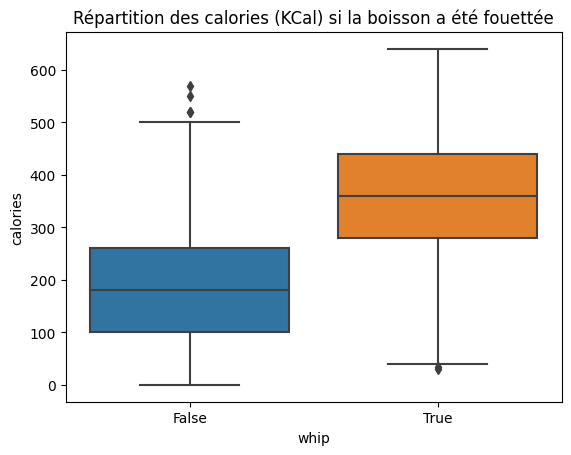

In [188]:
sns.boxplot(
    x="whip",
    y="sugar_g",
    data=starbucks
    ).set(title='Répartition du Sucre (g) si la boisson a été fouettée')
plot.show()

sns.boxplot(
    x="whip",
    y="serv_size_m_l",
    data=starbucks
    ).set(title='Répartition de la Taille servie (mL) si la boisson a été fouettée')
plot.show()

sns.boxplot(
    x="whip",
    y="calories",
    data=starbucks
    ).set(title='Répartition des calories (KCal) si la boisson a été fouettée')
plot.show()

## Exploration des corrélations

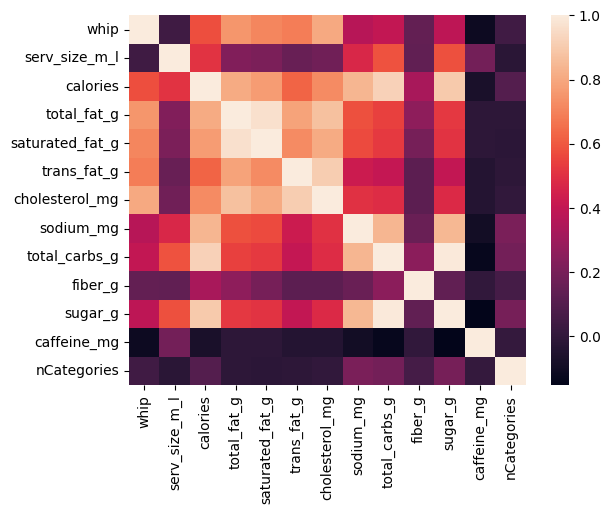

In [189]:
corr = starbucks.corr()
sns.heatmap(corr, annot = False)
plot.show()

### Calories et Sucres

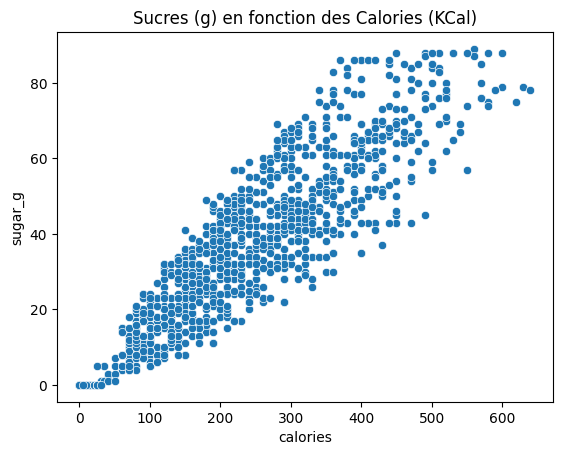

In [190]:
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    data = starbucks
    ).set(title='Sucres (g) en fonction des Calories (KCal)')
plot.show()

### Calories et Sodium

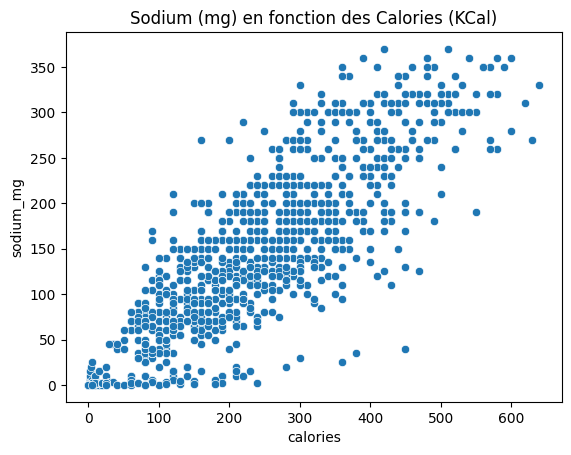

In [191]:
sns.scatterplot(
    x = "calories",
    y = "sodium_mg",
    data = starbucks
    ).set(title='Sodium (mg) en fonction des Calories (KCal)')
plot.show()

### Sucres et Glucides

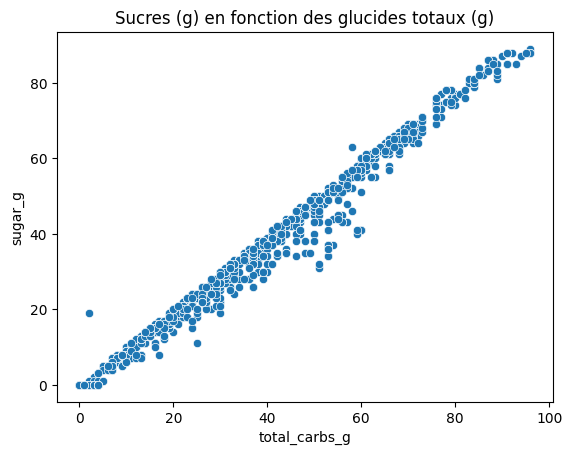

In [192]:
sns.scatterplot(
    x = "total_carbs_g",
    y = "sugar_g",
    data = starbucks
    ).set(title='Sucres (g) en fonction des glucides totaux (g)')
plot.show()

## Exploration multivariée des variables qualitatives

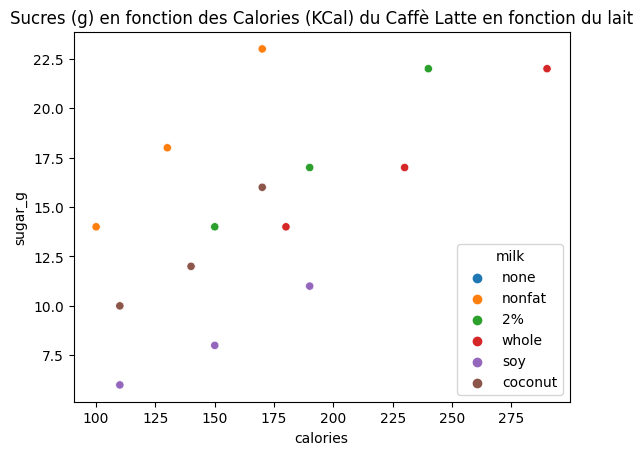

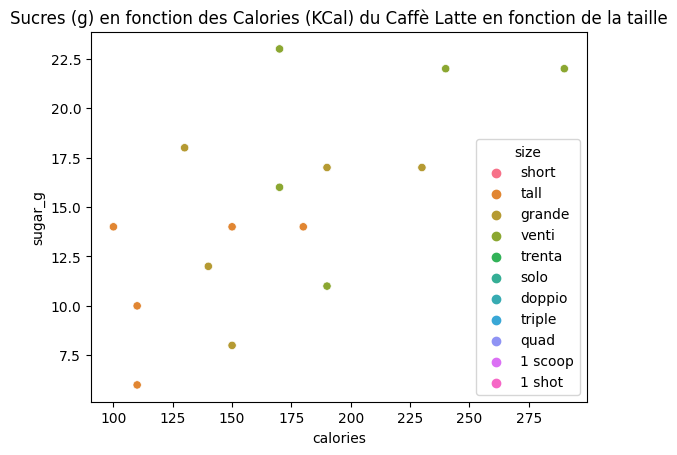

'\nsns.scatterplot(\n    x = "calories",\n    y = "sugar_g",\n    hue ="whip",\n    data = starbucks[starbucks["product_name"]=="Caffè Latte"],\n    legend = "brief"\n    ).set(title=\'Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction de whip\')\nplot.show()\n'

In [193]:
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="milk",
    data = starbucks[starbucks["product_name"]=="Caffè Latte"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction du lait')
plot.show()

sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="size",
    data = starbucks[starbucks["product_name"]=="Caffè Latte"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction de la taille')
plot.show()

'''
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="whip",
    data = starbucks[starbucks["product_name"]=="Caffè Latte"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction de whip')
plot.show()
'''

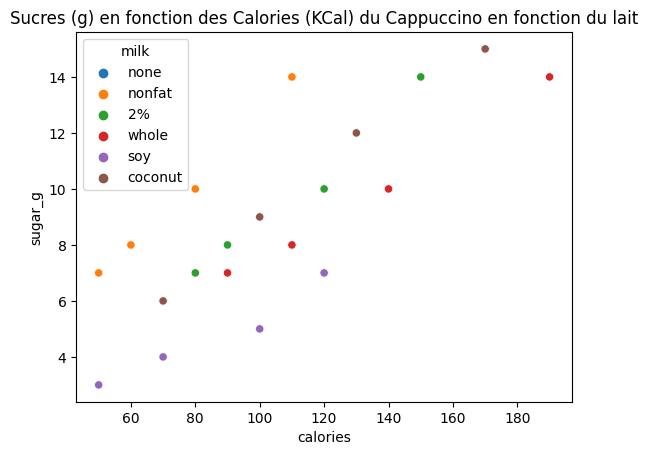

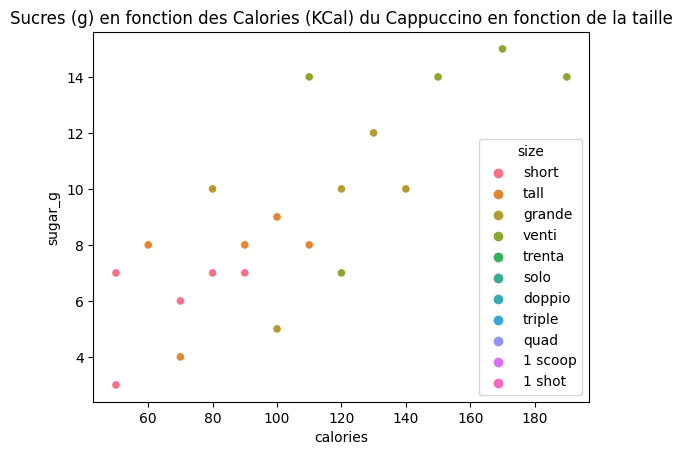

'\nsns.scatterplot(\n    x = "calories",\n    y = "sugar_g",\n    hue ="whip",\n    data = starbucks[starbucks["product_name"]=="Cappuccino"],\n    legend = "brief"\n    ).set(title=\'Sucres (g) en fonction des Calories (KCal) du Cappuccino en fonction de whip\')\nplot.show()\n'

In [194]:
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="milk",
    data = starbucks[starbucks["product_name"]=="Cappuccino"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Cappuccino en fonction du lait')
plot.show()

sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="size",
    data = starbucks[starbucks["product_name"]=="Cappuccino"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Cappuccino en fonction de la taille')
plot.show()
'''
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="whip",
    data = starbucks[starbucks["product_name"]=="Cappuccino"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Cappuccino en fonction de whip')
plot.show()
'''

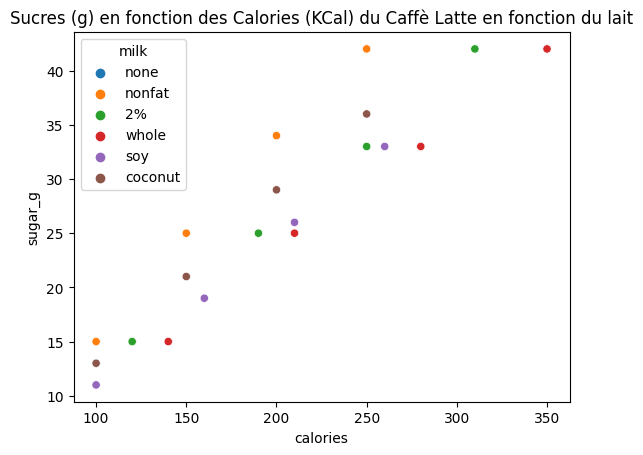

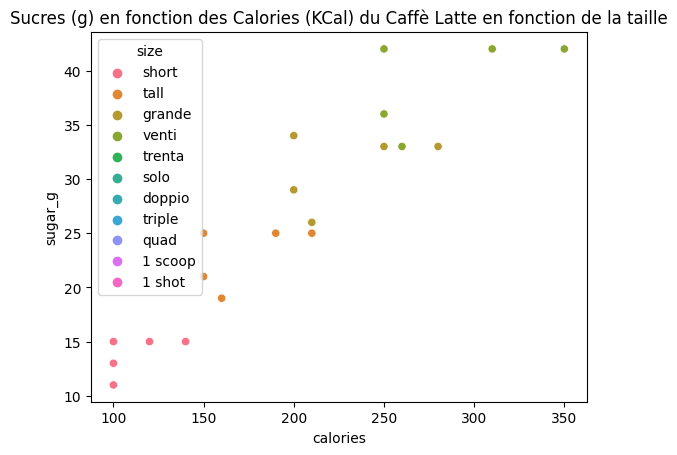

'\nsns.scatterplot(\n    x = "calories",\n    y = "sugar_g",\n    hue ="whip",\n    data = starbucks[starbucks["product_name"]=="Caramel Macchiato"],\n    legend = "brief"\n    ).set(title=\'Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction de whip\')\nplot.show()\n'

In [195]:
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="milk",
    data = starbucks[starbucks["product_name"]=="Caramel Macchiato"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction du lait')
plot.show()

sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="size",
    data = starbucks[starbucks["product_name"]=="Caramel Macchiato"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction de la taille')
plot.show()
'''
sns.scatterplot(
    x = "calories",
    y = "sugar_g",
    hue ="whip",
    data = starbucks[starbucks["product_name"]=="Caramel Macchiato"],
    legend = "brief"
    ).set(title='Sucres (g) en fonction des Calories (KCal) du Caffè Latte en fonction de whip')
plot.show()
'''

## Analyse en Composantes Principales

### Premier essai : Cluster sur la taille

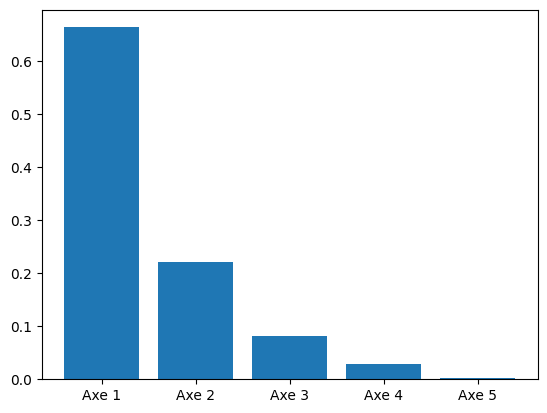

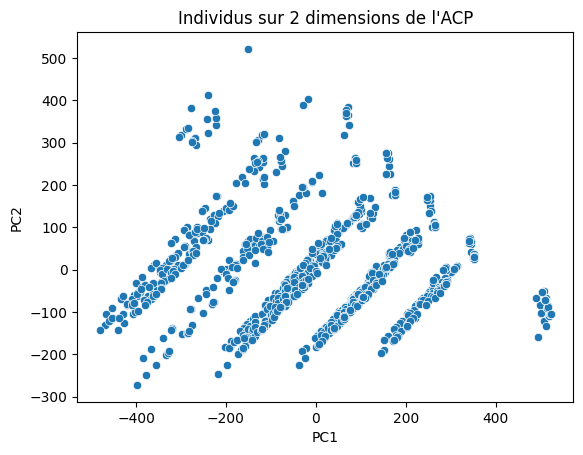

In [196]:
n_comp = 5
starbucks_acp1 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "Category"]).copy()

cls = PCA(n_components = n_comp)
pcs = cls.fit_transform(starbucks_acp1)

plot.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"],cls.explained_variance_ratio_)
plot.show()

for i in range(0, n_comp):
    starbucks['PC' + str(i + 1)] = pcs[:, i]

sns.scatterplot(x="PC1", y="PC2", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP")
plot.show()

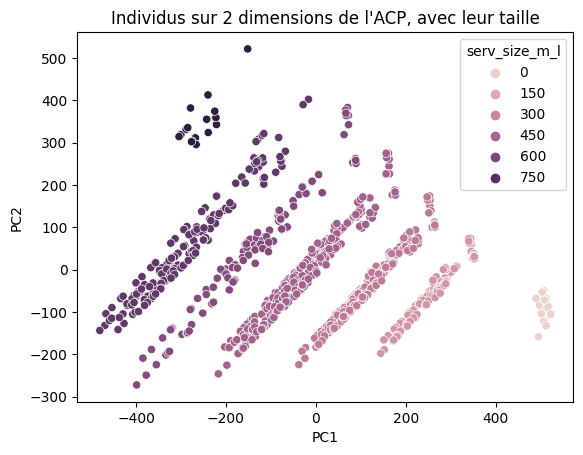

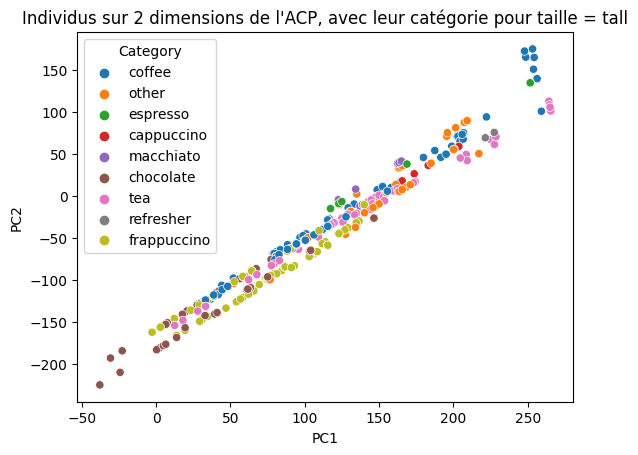

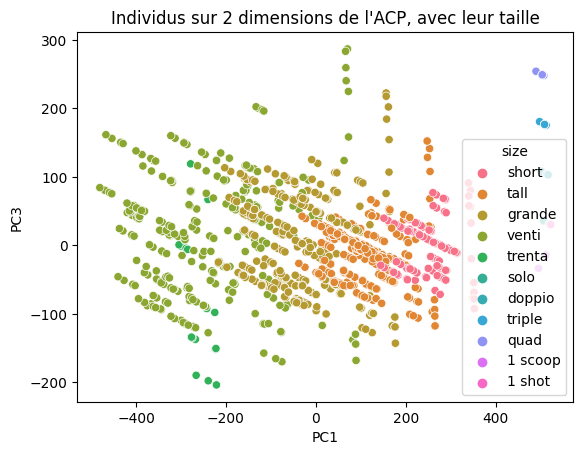

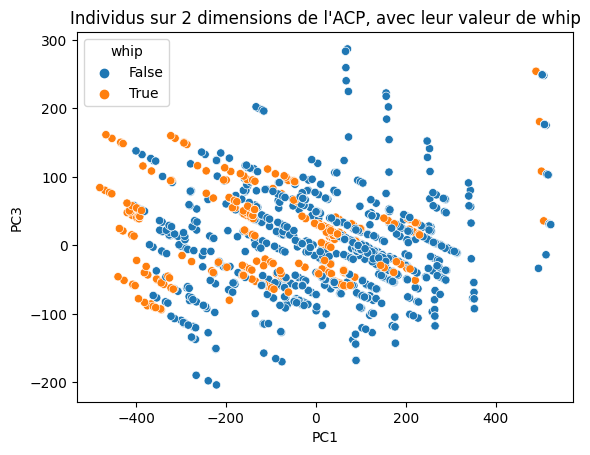

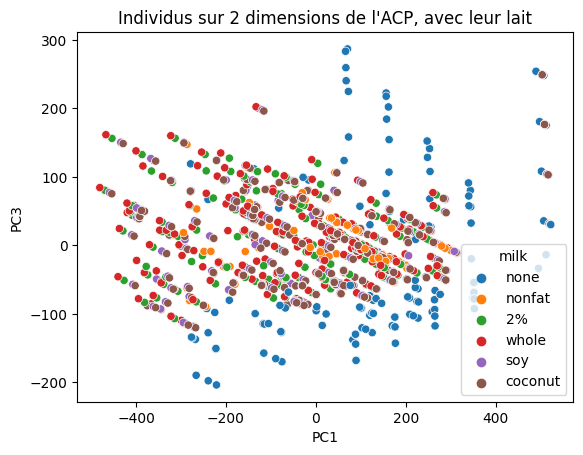

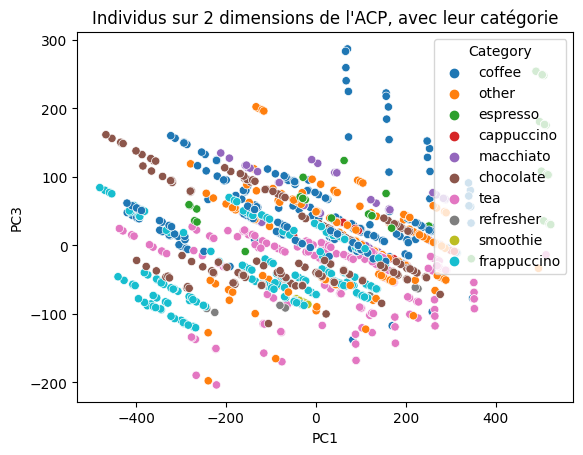

In [197]:
sns.scatterplot(x="PC1", y="PC2", hue="serv_size_m_l", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
plot.show()

################################################################################

sns.scatterplot(x="PC1", y="PC3", hue="size", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

sns.scatterplot(x="PC1", y="PC3", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC1", y="PC3", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC1", y="PC3", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()

#sns.scatterplot(x="PC1", y="PC3", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
#plot.show()

On trouve une ACP qui regroupe les boissons selon leur taille, mais on ne trouve rien de pertinent avec les variables *whip*, *milk* ou *category*. On essaye maintenant de qualifier les axes.

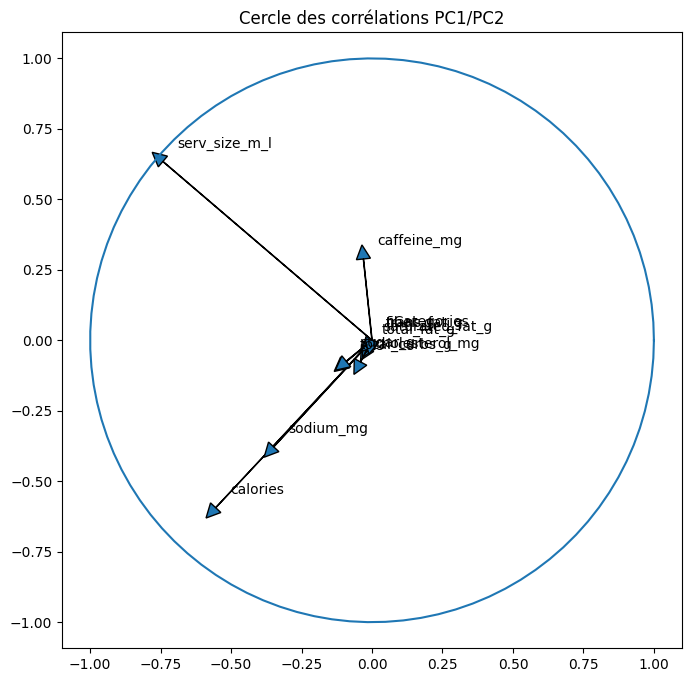

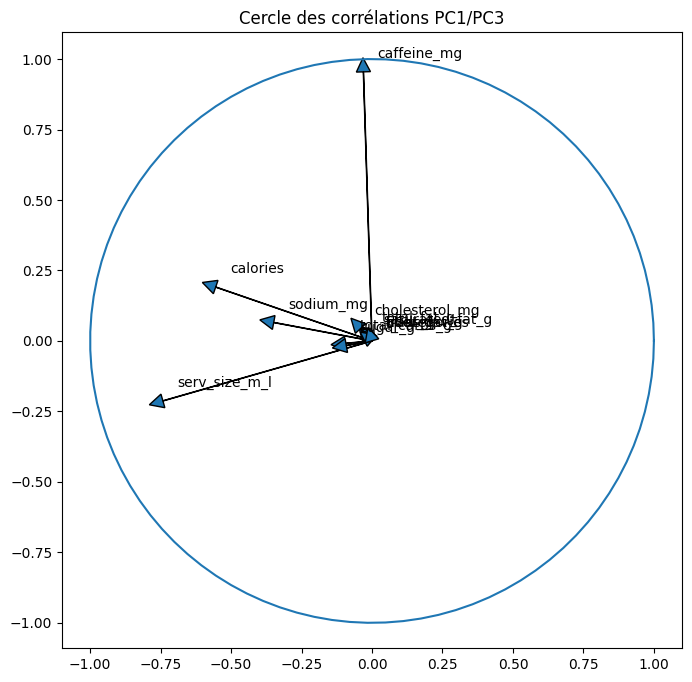

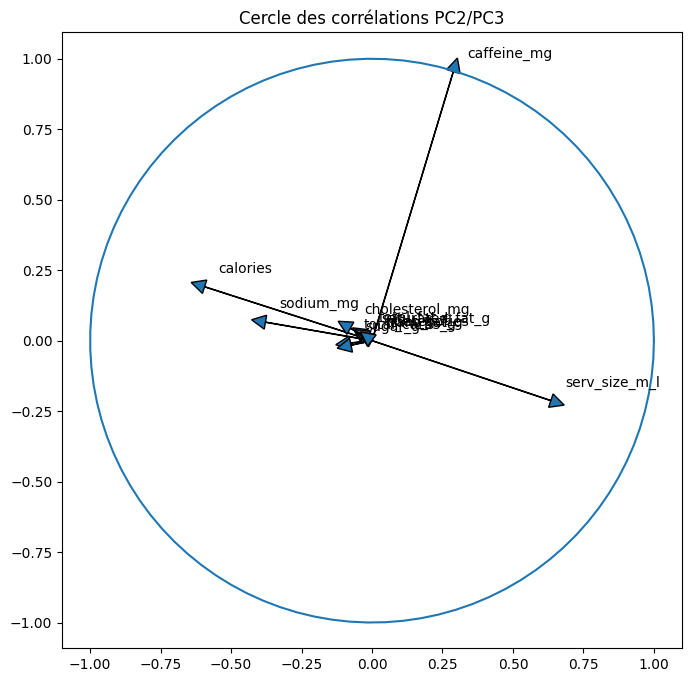

In [198]:
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls.components_[0, i],  #0 for PC1
             cls.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls.components_[0, i] + 0.05,
             cls.components_[1, i] + 0.05,
             starbucks_acp1.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC1/PC2')
plot.show()

#########################################################################################

(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls.components_[0, i],  #0 for PC1
             cls.components_[2, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls.components_[0, i] + 0.05,
             cls.components_[2, i] + 0.05,
             starbucks_acp1.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC1/PC3')
plot.show()

#########################################################################################

(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls.components_[1, i],  #0 for PC1
             cls.components_[2, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls.components_[1, i] + 0.05,
             cls.components_[2, i] + 0.05,
             starbucks_acp1.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC2/PC3')
plot.show()

### Deuxième essai : Sans *serv_size_m_l*

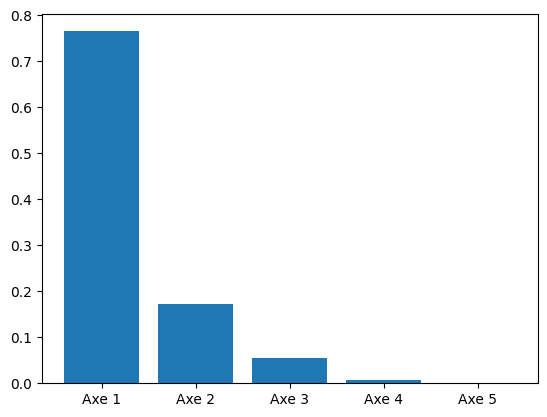

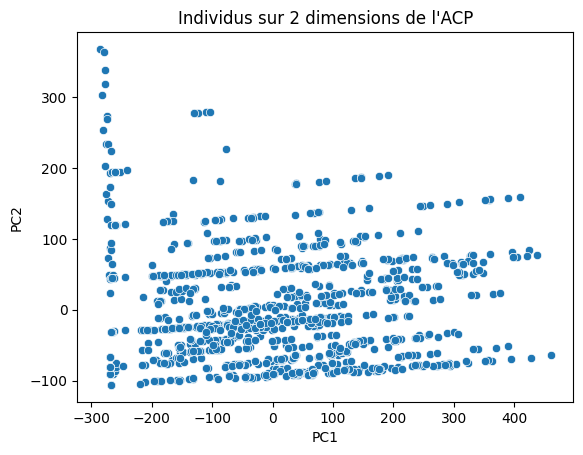

In [199]:
n_comp = 5
starbucks_acp2 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "Category", "serv_size_m_l", "PC1", "PC2", "PC3", "PC4", "PC5"]).copy()

cls2 = PCA(n_components = n_comp)
pcs2 = cls2.fit_transform(starbucks_acp2)

plot.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"],cls2.explained_variance_ratio_)
plot.show()

for i in range(0, n_comp):
    starbucks['PC' + str(i + 1)] = pcs2[:, i]

sns.scatterplot(x="PC1", y="PC2", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP")
plot.show()

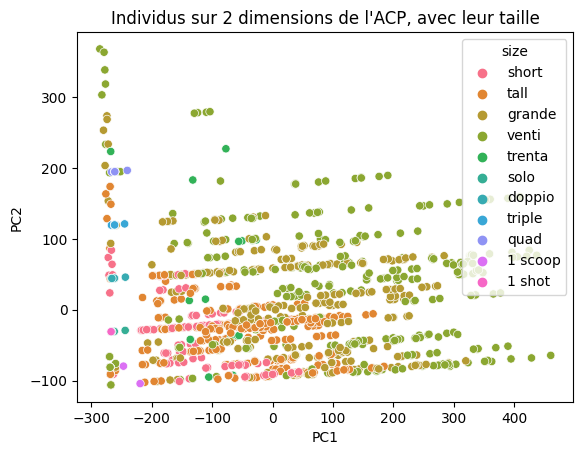

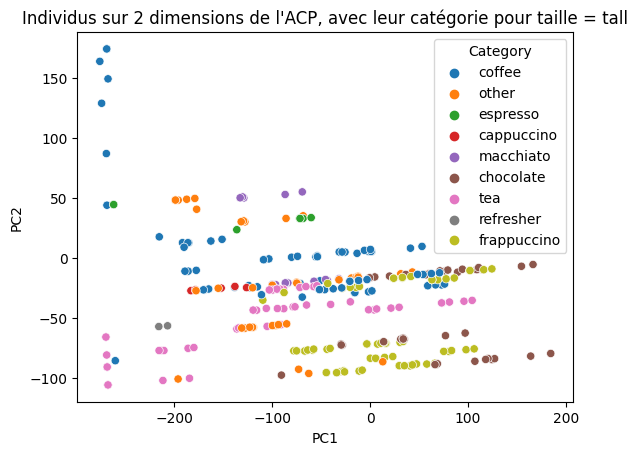

In [200]:
sns.scatterplot(x="PC1", y="PC2", hue="size", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()
'''
sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
plot.show()

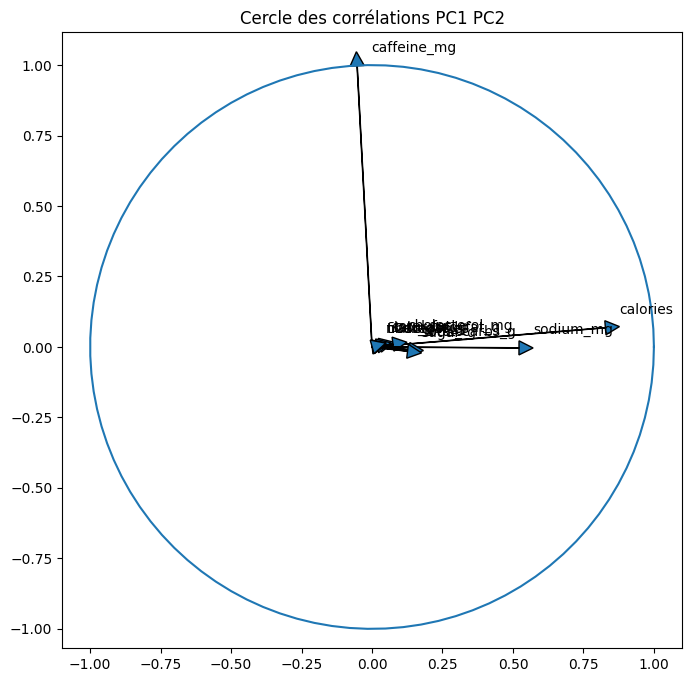

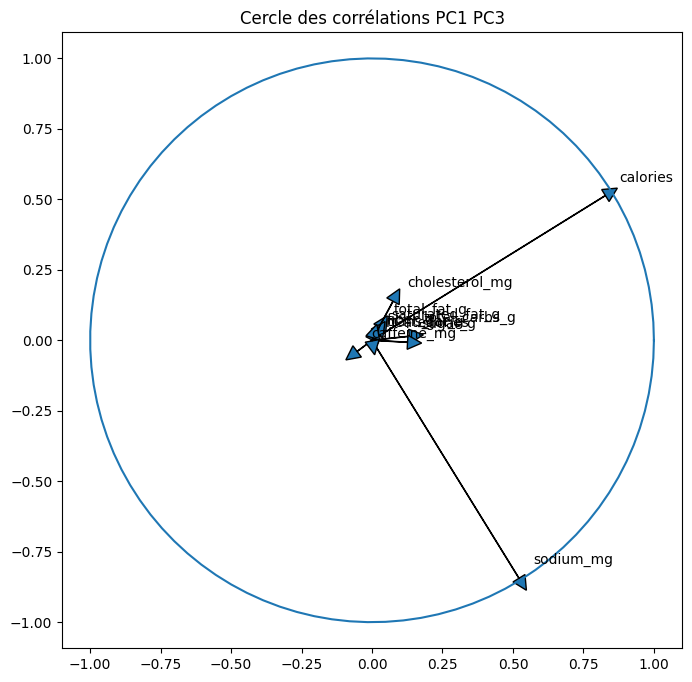

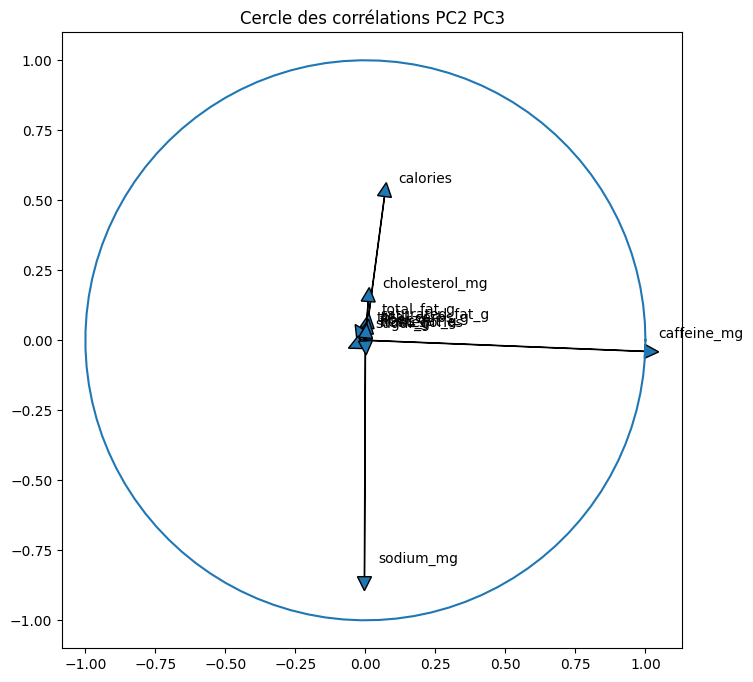

In [201]:
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls2.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls2.components_[0, i],  #0 for PC1
             cls2.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls2.components_[0, i] + 0.05,
             cls2.components_[1, i] + 0.05,
             starbucks_acp2.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC1 PC2')
plot.show()
##############################################################################################
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls2.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls2.components_[0, i],  #0 for PC1
             cls2.components_[2, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls2.components_[0, i] + 0.05,
             cls2.components_[2, i] + 0.05,
             starbucks_acp2.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC1 PC3')
plot.show()
##############################################################################################
(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls2.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls2.components_[1, i],  #0 for PC1
             cls2.components_[2, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls2.components_[1, i] + 0.05,
             cls2.components_[2, i] + 0.05,
             starbucks_acp2.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC2 PC3')
plot.show()

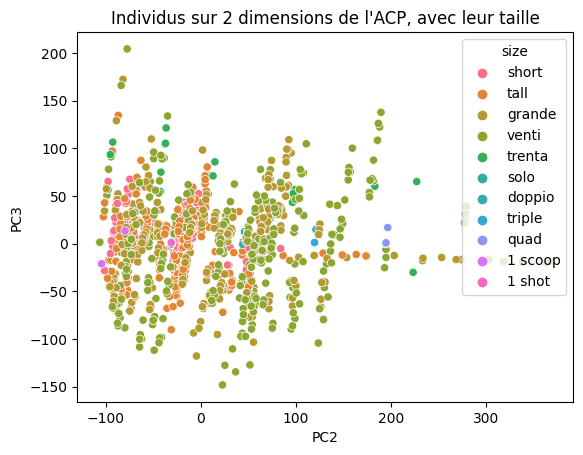

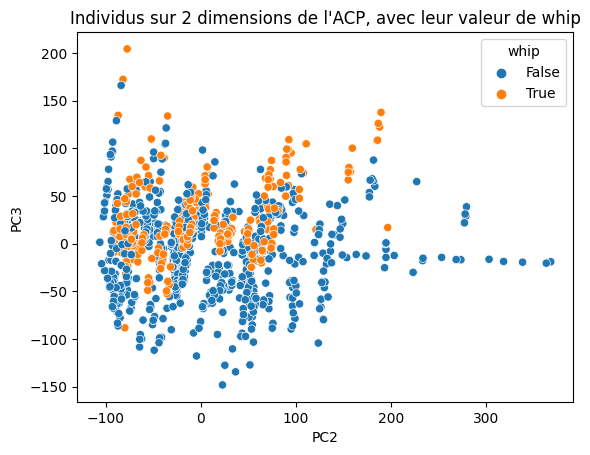

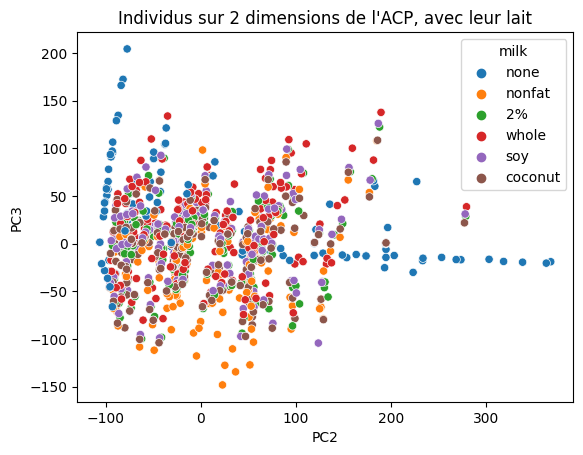

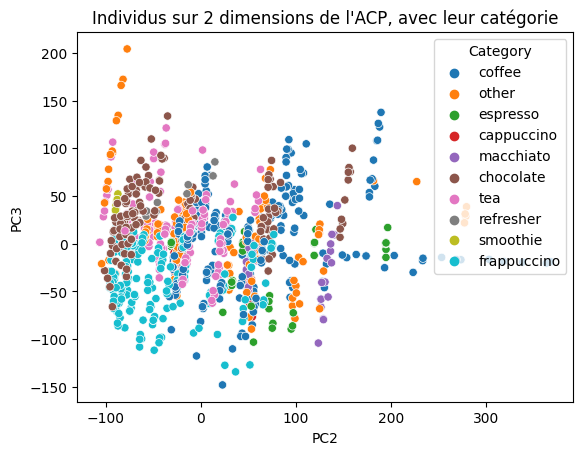

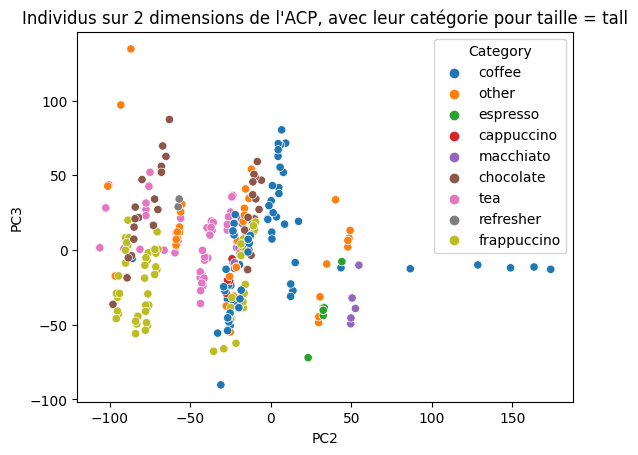

In [202]:
sns.scatterplot(x="PC2", y="PC3", hue="size", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

sns.scatterplot(x="PC2", y="PC3", hue="whip", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur valeur de whip")
plot.show()

sns.scatterplot(x="PC2", y="PC3", hue="milk", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur lait")
plot.show()

sns.scatterplot(x="PC2", y="PC3", hue="Category", data=starbucks).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie")
plot.show()

sns.scatterplot(x="PC2", y="PC3", hue="Category", data=starbucks[starbucks['size']=='tall']).set(title="Individus sur 2 dimensions de l'ACP, avec leur catégorie pour taille = tall")
plot.show()

### Troisième essai : Transformer les variables

Comme dans le jeu de données *crabs*, la première ACP concentre l'inertie sur un axe car toutes les variables dépendent fortement de la taille de la boisson.

On peut donc soit faire l'ACP sur une taille précise, soit transformer les variables pour les mettre dans une même dimension.

C'est ce que l'on va faire en divisant chaque valeur nutritionelle par la taille de la boisson pour obtenir des valeurs en concentration. Pour ça, on enlève les tailles spécifiques pour lesquelles *serv_size_m_l* est nul.

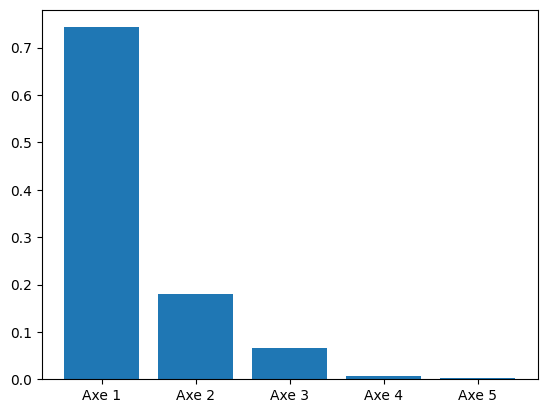

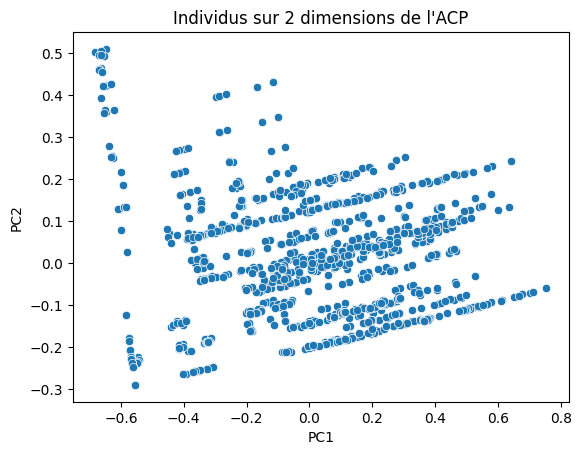

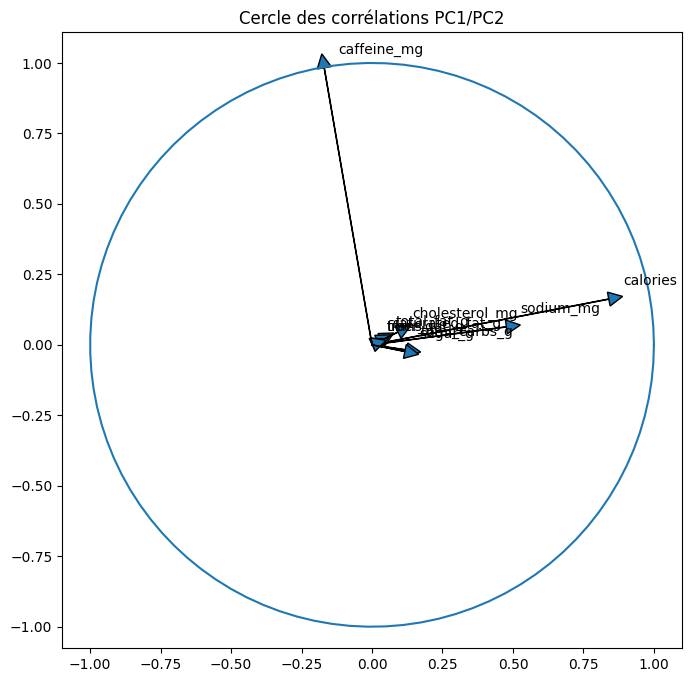

0.8898786797103266 0.21228525865351633 calories
0.08312037677992597 0.06812650476837993 total_fat_g
0.07143883633287718 0.061649314697323175 saturated_fat_g
0.05071313352260628 0.05034427682306243 trans_fat_g
0.1420012829155145 0.09523675378944865 cholesterol_mg
0.5265765540464514 0.11376962972168503 sodium_mg
0.17295585709572753 0.03171346228193836 total_carbs_g
0.05272918473780658 0.050855029914558356 fiber_g
0.1664771046883408 0.02641846078286166 sugar_g
-0.11960175901893917 1.0329521618528694 caffeine_mg


In [203]:
n_comp = 5
starbucks_acp4 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "Category", "nCategories", "PC1", "PC2", "PC3", "PC4", "PC5"]).copy()

starbucks_acp4 = starbucks_acp4[starbucks_acp4['serv_size_m_l'] != 0].copy()

for i in ['calories', 'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'total_carbs_g', 'fiber_g', 'sugar_g', 'caffeine_mg']:
    starbucks_acp4[i] = np.where(starbucks_acp4['serv_size_m_l'] == 0, starbucks_acp4[i], starbucks_acp4[i] / starbucks_acp4["serv_size_m_l"])

starbucks_acp4 = starbucks_acp4.drop(columns=["serv_size_m_l"]).copy()

starbucks_res = starbucks[starbucks['serv_size_m_l'] != 0].copy()

#########################################################################################

cls4 = PCA(n_components = n_comp)
pcs4 = cls4.fit_transform(starbucks_acp4)

plot.bar(["Axe 1", "Axe 2", "Axe 3", "Axe 4", "Axe 5"],cls4.explained_variance_ratio_)
plot.show()

for i in range(0, n_comp):
    starbucks_res['PC' + str(i + 1)] = pcs4[:, i]

sns.scatterplot(x="PC1", y="PC2", data=starbucks_res).set(title="Individus sur 2 dimensions de l'ACP")
plot.show()

#########################################################################################

(fig, ax) = plot.subplots(figsize=(8, 8))
for i in range(0, cls4.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             cls4.components_[0, i],  #0 for PC1
             cls4.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plot.text(cls4.components_[0, i] + 0.05,
             cls4.components_[1, i] + 0.05,
             starbucks_acp4.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plot.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plot.axis('equal')
ax.set_title('Cercle des corrélations PC1/PC2')
plot.show()

for i in range(0, cls4.components_.shape[1]):
    print(cls4.components_[0, i] + 0.05, cls4.components_[1, i] + 0.05, starbucks_acp4.columns.values[i])


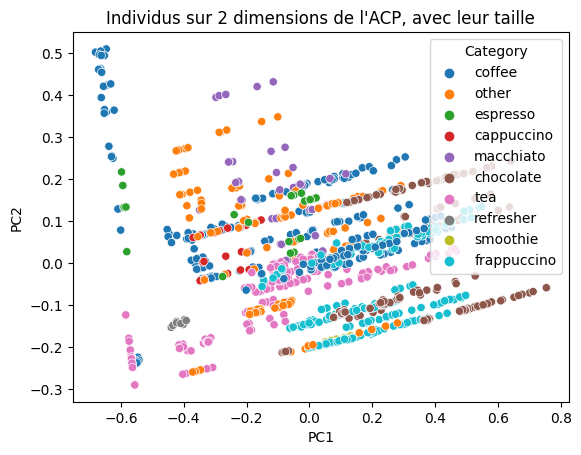

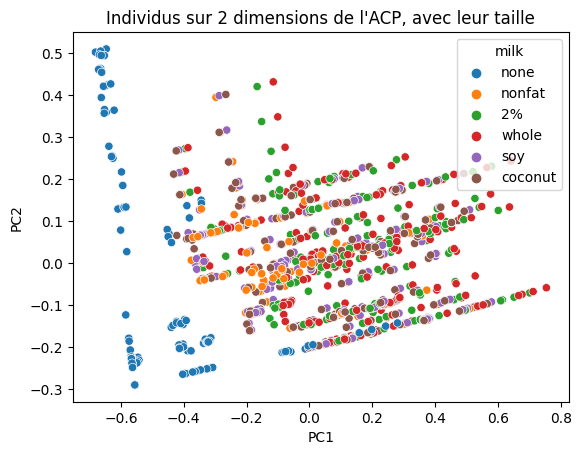

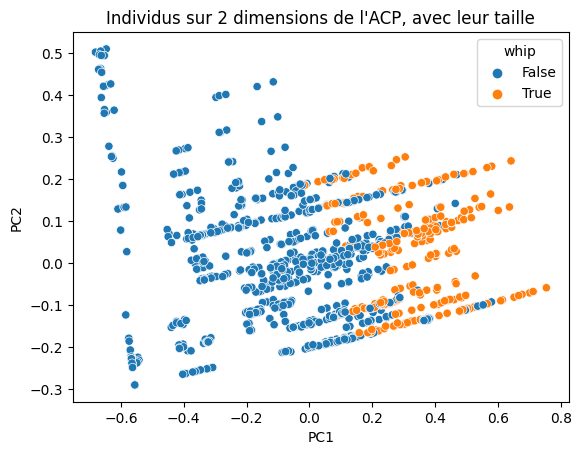

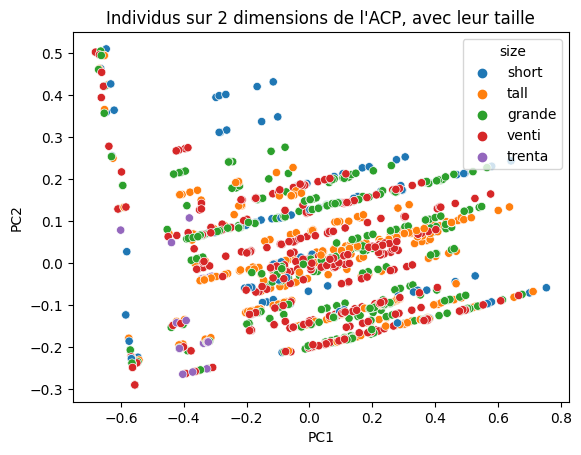

'\nprint(starbucks_acp4.shape)\nprint(starbucks_res.shape)\n\nfor i in [\'calories\', \'total_fat_g\', \'saturated_fat_g\', \'trans_fat_g\', \'cholesterol_mg\', \'sodium_mg\', \'total_carbs_g\', \'fiber_g\', \'sugar_g\', \'caffeine_mg\']:\n    print(i, " : ", starbucks_acp4[i].nunique(), " pour ", starbucks[i].nunique())\n    \nfor i in [\'calories\', \'total_fat_g\', \'saturated_fat_g\', \'trans_fat_g\', \'cholesterol_mg\', \'sodium_mg\', \'total_carbs_g\', \'fiber_g\', \'sugar_g\', \'caffeine_mg\']:\n    print(starbucks_acp4[i].describe())\n'

In [204]:
starbucks_res["size"] = pd.Categorical(starbucks_res["size"], categories = ['short', 'tall', 'grande', 'venti', 'trenta'])

sns.scatterplot(x="PC1", y="PC2", hue="Category", data=starbucks_res, legend = "brief"
               ).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="milk", data=starbucks_res, legend = "brief"
               ).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="whip", data=starbucks_res, legend = "brief"
               ).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

sns.scatterplot(x="PC1", y="PC2", hue="size", data=starbucks_res, legend = "brief"
               ).set(title="Individus sur 2 dimensions de l'ACP, avec leur taille")
plot.show()

'''
print(starbucks_acp4.shape)
print(starbucks_res.shape)

for i in ['calories', 'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'total_carbs_g', 'fiber_g', 'sugar_g', 'caffeine_mg']:
    print(i, " : ", starbucks_acp4[i].nunique(), " pour ", starbucks[i].nunique())
    
for i in ['calories', 'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'total_carbs_g', 'fiber_g', 'sugar_g', 'caffeine_mg']:
    print(starbucks_acp4[i].describe())
'''